### Project description: The aim is to develop a machine learning algorithm for correctly predicting sentiments using the pubicly availabe dataset  Sentiment140.

In [72]:
# Install this exact version of the emoji library 
!pip install emoji==1.6.3

Defaulting to user installation because normal site-packages is not writeable


### Imports

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re, string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from numpy import array
import tensorflow as tf
import seaborn as sns
import itertools
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

sns.set() # Use seaborn styles for graphs/figures
%matplotlib inline

### Import the dataset
##### For convenience, the dataset is uploaded to GitHub and being served from there.

In [191]:
dataset_url = ('https://raw.githubusercontent.com/abdulaihalidu/Abo-Akademi-Machine-Learning/main/Sentiment%20Analysis%20with%20the%20'
'sentiment140%20dataset/Sentiment140.tenPercent.sample.tweets.tsv')
# Read in the dataset using pandas
def load_dataset(url, sep='\t'):
    data = pd.read_csv(url, sep=sep)
    return data
sentiment140 = load_dataset(dataset_url)

In [192]:
# Define a method to check the first few rows of the dataset to have an understanding of what the dataset is comprised of,
# And to also check for null values
def dataset_overview(data) -> None:
    print("First few roles of the dataset")
    print(data.head())
    print()
    print("*" * 100)
    print("\nChecking for null values")
    print(data.isnull().sum())
    print("*" * 100)
    print(f"The shape of the dataset is {sentiment140.shape}")
# call the method
dataset_overview(sentiment140)

First few roles of the dataset
   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...

****************************************************************************************************

Checking for null values
sentiment_label    0
tweet_text         0
dtype: int64
****************************************************************************************************
The shape of the dataset is (160000, 2)


### General comments on the datasetd
- The first few roles review that the dataset is quite 'dirty' and needs cleaning
- Though not necessary for some models, the target variable (sentiment_label) isn't in the traditional (0, 1) format for a binary classification problem. For the sake of some model types, the values for the target variable will be transformed into 0s and 1s to designate negative and positive sentiments respectively.
- For some stupid reasons, I like to have the target variable at the last column, so that transformation will also be performed. Pardon me for this total unnecessary thing 😑

In [193]:
# Re-arrange the columns to have the target variable at the last column
sentiment140_data = sentiment140[["tweet_text", "sentiment_label"]]
sentiment140_data.head()

,tweet_text,sentiment_label
0,"@elephantbird Hey dear, Happy Friday to You A...",4
1,Ughhh layin downnnn Waiting for zeina to co...,4
2,"@greeniebach I reckon he'll play, even if he's...",0
3,@vaLewee I know! Saw it on the news!,0
4,very sad that http://www.fabchannel.com/ has c...,0


In [194]:
# Define a method to change the lables 0, 4 to Negative - Positive respectively
labels_to_sentiment = {0:"Negative", 4:"Positive"}

def label_decoder(label):
    return labels_to_sentiment[label]

# Change the labels 0 and 4 to Negative and Positive respectively
sentiment140_data.sentiment_label = sentiment140_data.sentiment_label.apply(lambda x: label_decoder(x))

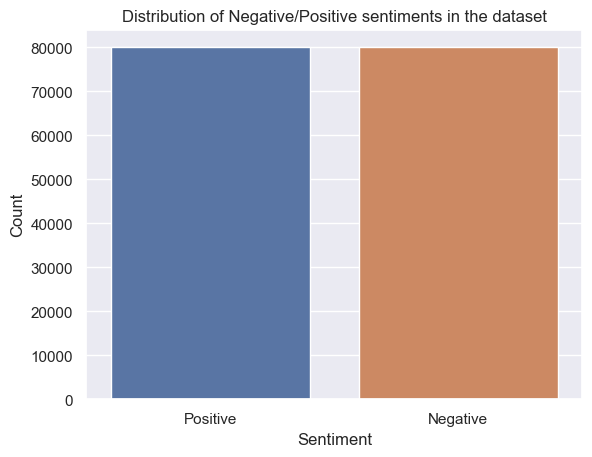

In [195]:
# Next, let's check the distribution of the positive(4)/negative(0) sentiments
sns.countplot(x='sentiment_label', data=sentiment140_data)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Negative/Positive sentiments in the dataset")
plt.show()

#### The dataset seems to have an equal number of positive and negative texts. Next, let's jump straight to data preprocessing
## Data preprocessing

In [196]:
# Let's select a random text to view it. This will help us have an understaning of the kind of characters present in the dataset,
# and to enable us perform the necessary data cleaning
for text in sentiment140_data['tweet_text'][:10]:
    print(text)

@elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Ughhh layin downnnn    Waiting for zeina to cook breakfast
@greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
@vaLewee I know!  Saw it on the news!
very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
@Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
With God on ur side anything is possible.... 
@LoveSmrs why being stupid? 
Having delved back into the guts of Expression Engine, its a flexible CMS if you have to use it as a dev, not great for clients though 
@emoskank awww   take him with you!


#### The output from the cell above indicates that:
- Some tweets start with the '@' symbol. We will have to remove mentions (words that start with the @ symbol)
- Also, there are some characters that needs to be replaced.(e.g, !, ;, ...)
- There are http tags that need to be taken care of
##### Okay, there's jump straight into it!

##### Data cleaning

In [197]:
#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    # remove links, mentions, and numbers
    text = re.sub(r"(?:\@|https?\://)\S+|\d+", "", text)
    # remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) 
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)
# remove multiple spaces
def remove_mult_spaces(text, stem=True): 
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    text = " ".join(tokens).strip()
    return re.sub("\s\s+" , " ", text)
    


In [200]:
# Set up stopwords
stop_words = set(stopwords.words('english'))
# Initialize PorterStemmer 
stemmer = PorterStemmer() 

In [201]:
def clean_text(text, stem=False):
    # Replace \r and \n with space, and lowercase the text
    text = re.sub(r'[\r\n]+', ' ', text).lower()
    
    # Remove emojis
    # Uncomment the following line if emoji cleaning is needed and the emoji module is available
    # text = re.sub(emoji.get_emoji_regexp(), "", text)
    
    # Remove links, mentions, numbers, and non-ASCII characters
    text = re.sub(r"(?:\@|https?\://)\S+|\d+|[^\x00-\x7f]", "", text)
    
    # Remove punctuation and certain special characters
    banned_list = string.punctuation + 'Ã±ã¼â»§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    
    # Clean hashtags, remove $ and &, and reduce multiple spaces
    words = []
    for word in text.split():
        # Filter out words with $ and &, and remove single-character words
        if ('$' not in word) and ('&' not in word) and len(word) > 1:
            # Handle hashtags and underscores
            word = re.sub(r'#|_', '', word)
            # Optionally apply stemming
            if stem:
                word = stemmer.stem(word)
            words.append(word)
    
    # Join words and remove multiple spaces
    cleaned_text = " ".join(words).strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    
    return cleaned_text

##### The cell below takes a while to run, be patient 

In [202]:
# clean each text column of the dataset 
def clean_dataset(data, column_to_clean) -> None:
    cleaned_tweet_text = []
    for t in data[column_to_clean]:
        cleaned_tweet_text.append(clean_text(t))
    return cleaned_tweet_text

# call the function
cleaned_tweet_text = clean_dataset(sentiment140_data, column_to_clean="tweet_text")

In [203]:
sentiment140_data["cleaned_tweet_text"] = cleaned_tweet_text
# Before splitting the data, let's convert the target variable to 0s and 1s.
sentiment140_data.head()

,tweet_text,sentiment_label,cleaned_tweet_text
0,"@elephantbird Hey dear, Happy Friday to You A...",Positive,hey dear happy friday to you already had your ...
1,Ughhh layin downnnn Waiting for zeina to co...,Positive,ughhh layin downnnn waiting for zeina to cook ...
2,"@greeniebach I reckon he'll play, even if he's...",Negative,reckon hell play even if hes not but know noth...
3,@vaLewee I know! Saw it on the news!,Negative,know saw it on the news
4,very sad that http://www.fabchannel.com/ has c...,Negative,very sad that has closed down one of the few w...


### This looks great so far, let's visualize each sentiment type (Positive/Negative) separately using wordcloud

In [204]:
# Define a function to take care of this
def visualize_word_cloud(df, sentiment_type="Positive") -> None:
    plt.figure(figsize=(15,15))
    word_cloud = WordCloud(max_words=2000,width=1600,
                           height=800, random_state=33).generate(" ".join(df[df.sentiment_label == sentiment_type].cleaned_tweet_text))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.show()

## Word cloud for Positively annotated tweets

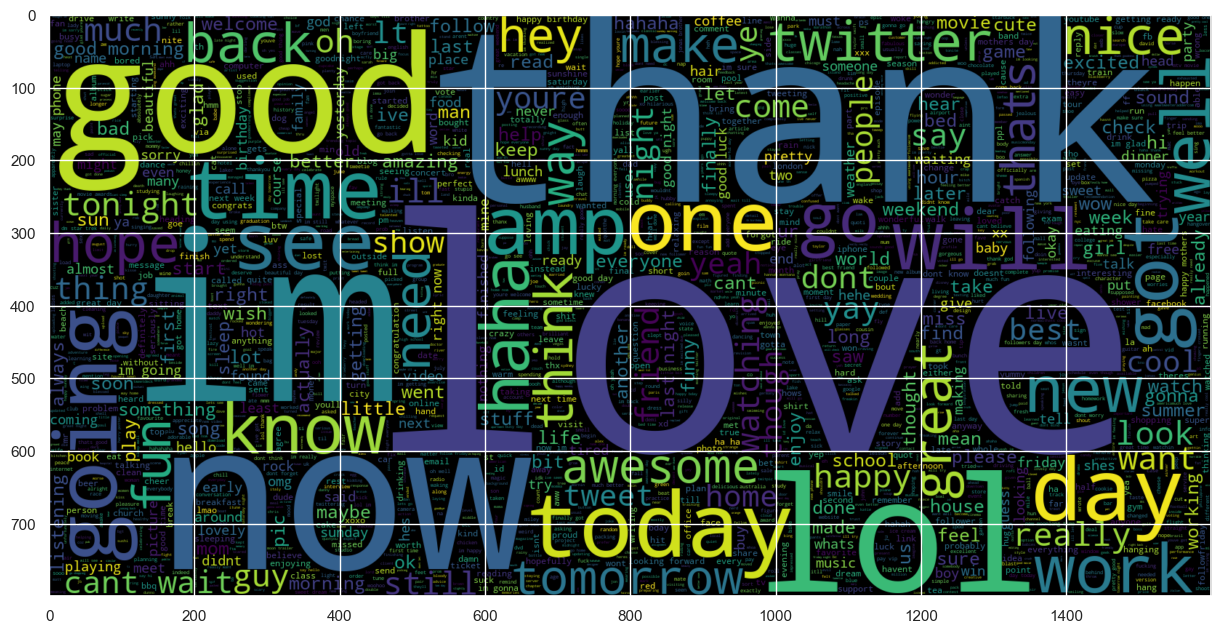

In [205]:
visualize_word_cloud(sentiment140_data, "Positive")

## Word cloud for Negative-sentiment annotated tweets

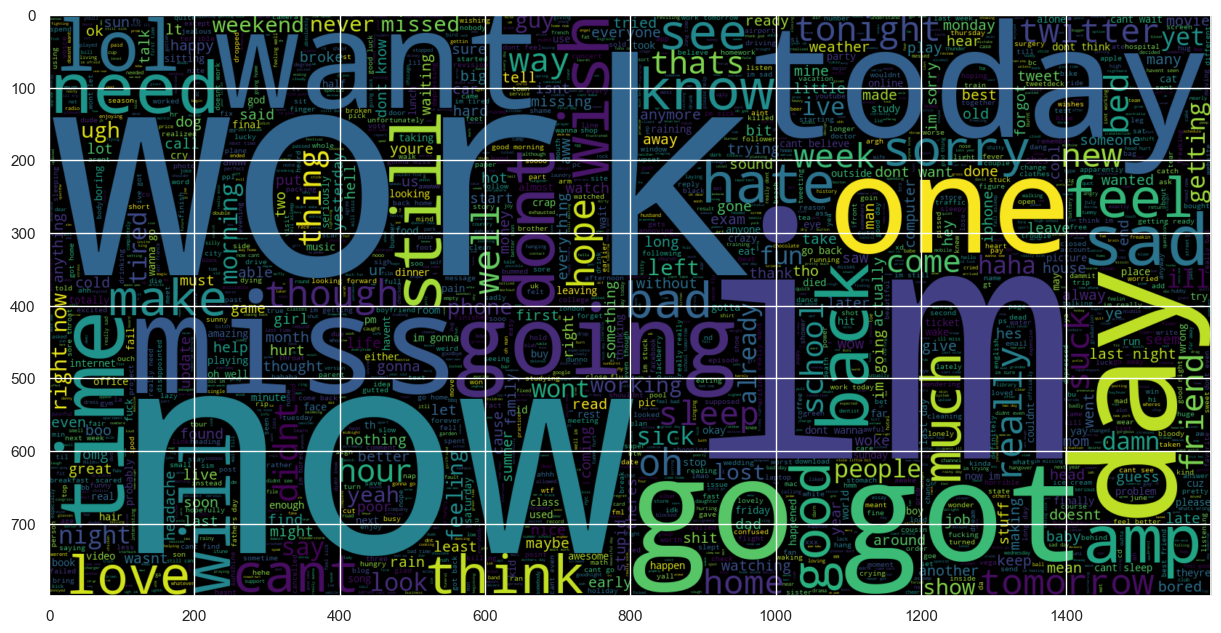

In [206]:
visualize_word_cloud(sentiment140_data, "Negative")

#### From the two word clouds above, we can see that some words such as 'now' and 'today' appears in both positive and negative tweets, but with different frequencies

In [207]:
# Before splitting the data, let's convert the target variable to 0s and 1s.
sentiment140_data.sentiment_label = np.array(list(map(lambda x: 1 if x=="Positive" else 0, sentiment140_data.sentiment_label)))
sentiment140_data.head()

,tweet_text,sentiment_label,cleaned_tweet_text
0,"@elephantbird Hey dear, Happy Friday to You A...",1,hey dear happy friday to you already had your ...
1,Ughhh layin downnnn Waiting for zeina to co...,1,ughhh layin downnnn waiting for zeina to cook ...
2,"@greeniebach I reckon he'll play, even if he's...",0,reckon hell play even if hes not but know noth...
3,@vaLewee I know! Saw it on the news!,0,know saw it on the news
4,very sad that http://www.fabchannel.com/ has c...,0,very sad that has closed down one of the few w...


### Constant Variables

In [208]:
# Test size
TEST_SIZE = 0.10
RANDOM_STATE = 3

### Train-Test split

In [209]:
X_train, X_test, y_train, y_test = train_test_split(sentiment140_data.cleaned_tweet_text, sentiment140_data.sentiment_label,
                                                    test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [210]:
X_train.head()

77425    so beautiful today so happy to have my bike back
76589                  fair enoughbecame your th follower
43120                      having fun going to alti later
49762                 noooooo its kicking off between and
24950             coda crashes my system daily back to dw
Name: cleaned_tweet_text, dtype: object

##### Feature extraction with CountVectorizer and TfidfTransformer for logistic regression 

In [211]:
cnt_vec = CountVectorizer()
X_train_cv =  cnt_vec.fit_transform(X_train)
X_test_cv = cnt_vec.transform(X_test)

In [212]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

### Classification with logistic Regression

In [213]:
# Instantiate a Logistic Regression classifier
log_clf = LogisticRegression(max_iter=10000)
# Fit the model on the training data
log_clf.fit(X_train_tf, y_train)

LogisticRegression(max_iter=10000)

In [214]:
# Make predictions on the test dataset
log_clf_pred = log_clf.predict(X_test_tf)

In [250]:
# Display the classification the results of the logistic regression classifier
print('\tClassification Report for Logistic Regression Classifier:\n\n',
      classification_report(y_test, log_clf_pred, target_names=['Negative', 'Positive']))

	Classification Report for Logistic Regression Classifier:

               precision    recall  f1-score   support

    Negative       0.78      0.78      0.78      7864
    Positive       0.79      0.79      0.79      8136

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



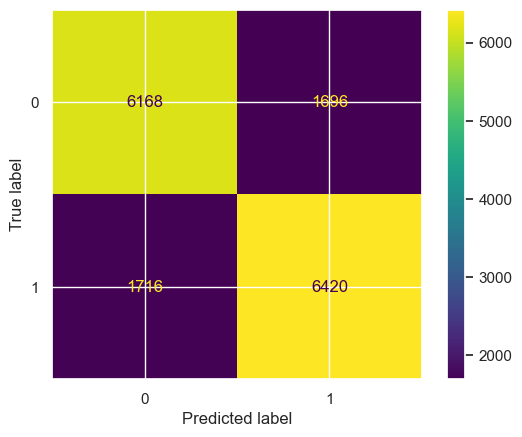

In [249]:
cm = confusion_matrix(y_test, log_clf_pred, labels=log_clf.classes_)
log_clf_cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_clf.classes_)
log_clf_cm_disp.plot()
plt.show()

### Classification with a deep learning model (LSTM)

In [216]:
# Constants
MAX_NB_WORDS = 100000
# length of each sequence
MAX_SEQUENCE_LENGTH = 100

### Tokenization

In [217]:
# Instantiate a tokenizer object
tokenizer=Tokenizer()
# Create word index
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)+1
print(f"The size of the vocab is: {vocab_size}")

The size of the vocab is: 81809


#### texts_to_sequences converts text sequences in training data into sequences of numerical indices using fitted tokenizer

In [218]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (144000, 100)
Testing X Shape: (16000, 100)


In [219]:
# Target variable
print(f"Shape of training target: {y_train.shape}")
print(f"Shape of testing target: {y_test.shape}")

Shape of training target: (144000,)
Shape of testing target: (16000,)


In [47]:
#download pretrained GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-02-20 16:38:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-20 16:38:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-20 16:38:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### Word Embeddings
- I will be using the pre-trained glove.6B.300d embedding to create the word embeddings vector for the deep learning models
- Make sure you have run the cell above to download it from the given link

In [220]:
GLOVE_EMB_PATH = "./glove.6B.300d.txt"
# Embedding dimension
EMBEDDING_DIM = 300
# Learning rate
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.25
SPATIAL_DROPOUT_RATE = 0.25
LSTM_UNITS = 128
CONV_FILTERS = 64
CONV_KERNEL_SIZE = 3
DENSE_UNITS = 512


In [221]:
#loading pre trained word emb from GloVe file
embeddings_index = {}

f = open(GLOVE_EMB_PATH, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [222]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Now that we have the dataset prepared, it's time to jump straight into the modelling phase
## Modelling

In [223]:
def define_LSTM_model():
    # Model definition
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='sequence_input')
    embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
                                                    input_length=MAX_SEQUENCE_LENGTH, trainable=False,
                                                                                name='embedding_layer')
    embedding_sequences = embedding_layer(sequence_input)
    
    # Spatial dropout to reduce overfitting in the embedding layer
    spatial_dropout = SpatialDropout1D(SPATIAL_DROPOUT_RATE)(embedding_sequences)
    
    # Convolution layer to extract features
    conv_layer = Conv1D(CONV_FILTERS, CONV_KERNEL_SIZE, activation='relu', name='conv_layer')(spatial_dropout)
    
    # Bidirectional LSTM to capture dependencies
    bi_lstm = Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECURRENT_DROPOUT_RATE), name='bi_lstm')(conv_layer)
    
    # Dense layers for classification
    dense_layer_1 = Dense(DENSE_UNITS, activation='relu', name='dense_layer_1')(bi_lstm)
    dropout_layer = Dropout(DROPOUT_RATE, name='dropout_layer')(dense_layer_1)
    dense_layer_2 = Dense(DENSE_UNITS, activation='relu', name='dense_layer_2')(dropout_layer)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid', name='output_layer')(dense_layer_2)
    
    model = Model(sequence_input, outputs, name='Sentiment_analysis_model')
    return model

In [224]:
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                         min_lr = 0.01,
                                         monitor = 'val_loss',
                                         verbose = 1)

In [225]:
def compile_and_visualize_LSTM_model():
    model = define_LSTM_model()
    model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
                  metrics=['accuracy'])
    # Visualize the architecture of the model
    print("\n\t\tLSTM MODEL ARCHITECTURE\n")
    model.summary()
    return model

lstm_model = compile_and_visualize_LSTM_model()


		LSTM MODEL ARCHITECTURE

Model: "Sentiment_analysis_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_input (InputLayer)  [(None, 100)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 100, 300)         24542700  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 100, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv_layer (Conv1D)         (None, 98, 64)            57664     
                                                                 
 bi_lstm (Bidirectional)     (None, 256)               197632    
                                                                 
 dense_layer_1 (Dense)       (None, 512)               131584    
              

In [226]:
def train_model(model):
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])
    return history

In [227]:
lstm_history = train_model(lstm_model)

Epoch 1/10
141/141 [==============================] - 279s 2s/step - loss: 0.5740 - accuracy: 0.6940 - val_loss: 0.5055 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 2/10
141/141 [==============================] - 261s 2s/step - loss: 0.5135 - accuracy: 0.7447 - val_loss: 0.4788 - val_accuracy: 0.7725 - lr: 0.0010
Epoch 3/10
141/141 [==============================] - 268s 2s/step - loss: 0.4935 - accuracy: 0.7596 - val_loss: 0.4725 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 4/10
141/141 [==============================] - 263s 2s/step - loss: 0.4795 - accuracy: 0.7675 - val_loss: 0.4608 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 5/10
141/141 [==============================] - 264s 2s/step - loss: 0.4684 - accuracy: 0.7747 - val_loss: 0.4592 - val_accuracy: 0.7828 - lr: 0.0010
Epoch 6/10
141/141 [==============================] - 261s 2s/step - loss: 0.4605 - accuracy: 0.7803 - val_loss: 0.4534 - val_accuracy: 0.7866 - lr: 0.0010
Epoch 7/10
141/141 [==============================] - 293s 2s/st

### Model Evaluation

****************************************************************************************************


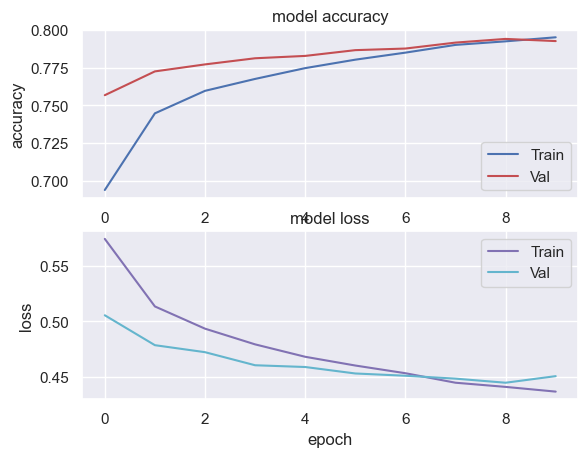

In [229]:
def evaluate_lstm_model(history) -> None:
    s, (at, al) = plt.subplots(2,1)
    at.plot(history.history['accuracy'], c= 'b')
    at.plot(history.history['val_accuracy'], c='r')
    at.set_title('model accuracy')
    at.set_ylabel('accuracy')
    at.set_xlabel('epoch')
    at.legend(['Train', 'Val'], loc='lower right')
    print("*" * 100)
    al.plot(history.history['loss'], c='m')
    al.plot(history.history['val_loss'], c='c')
    al.set_title('model loss')
    al.set_ylabel('loss')
    al.set_xlabel('epoch')
    al.legend(['Train', 'Val'], loc = 'upper right')
    plt.show()

# Call the function
evaluate_lstm_model(lstm_history)

In [230]:
def decode_sentiment(score):
    return 1 if score > 0.5 else 0


scores = lstm_model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

2/2 [==============================] - 4s 1s/step


In [231]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    #fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.show()

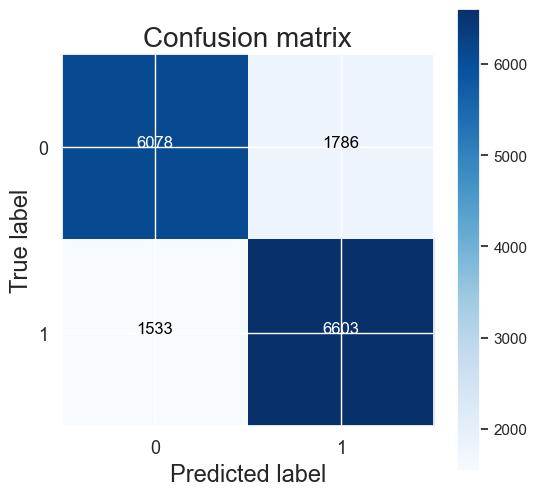

In [232]:
cnf_matrix = confusion_matrix(y_test, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title="Confusion matrix")

In [233]:
print(classification_report(y_test, y_pred_1d))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      7864
           1       0.79      0.81      0.80      8136

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



### Comparison of the performance of the two models (Logistic Regression Vs. LSTM model)

In [246]:
def compare_model_results() -> None:
    print("*" * 20, "Results of the Logistic Regression Classifier", "*" * 20, "\n")
    print(f'{classification_report(y_test, log_clf_pred)}')
    print("\n")
    print("*" * 20, "Results of the LSTM (Deep Learning) Classifier", "*" * 20, "\n")
    print(f'{classification_report(y_test, y_pred_1d)}')
compare_model_results()

******************** Results of the Logistic Regression Classifier ******************** 

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      7864
           1       0.79      0.79      0.79      8136

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



******************** Results of the LSTM (Deep Learning) Classifier ******************** 

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      7864
           1       0.79      0.81      0.80      8136

    accuracy                           0.79     16000
   macro avg       0.79      0.79      0.79     16000
weighted avg       0.79      0.79      0.79     16000



#### From the results above, we can draw the following conclusions:
- We can observe that the two models have a very similar performance level on the dataset.
- The LSTM model however has a slightly better precision-recall balance (evident in the slightly higher f1 score)
- Given that this  is an NLP problem, we'd expect the deep learning model (LSTM) to perform better than the classic model (Logistic regression model). However, Given the size of the dataset employed in this task, this performance difference wasn't something that I was actually expecting.
- In addition, I believe that a better preprocessing technique might lead to a slightly better result from the LSTM model. Even though I utilized the glove pretrained word embeddings in this project, the preprocessing techniques I used was rather simple in my opinion.
- It will be a good idea to try other preprocessing techniques to see thhe effect.
- Further comments can be found on the report file